
<h3>EVPI and EVPXI Calculation for ICU bed preparedness based on $R_0$, Case Seveirity and Child Infectiousness </h3>
Both single parameter and combined parameter analysis were carried out. <br>

References:

Making the best use of experts' estimates to prioritise monitoring and management actions: A freshwater case study (https://doi.org/10.1016/j.jenvman.2018.03.068)

https://wiki.analytica.com/index.php?title=Expected_value_of_information_--_EVI,_EVPI,_and_ESVI&title=Expected_value_of_information_--_EVI,_EVPI,_and_ESVI

In [1]:
#Important library importation
import numpy as np
#import warnings
import copy
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd
import seaborn as sns
from itertools import chain

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


<h2> Data for VoI study</h2>
0 - CI05,1 - CI95, 2 - Mean

### Load output of Transmission model and Model of Care Simulation Data from Excel Sheets

In [27]:

r4_df = pd.read_excel(r'C:\Users\ezep\Desktop\SPARKSPECTRUM\Data\EVPXIData2.xlsx', sheet_name='Fiji Urban',header=None)
r4_df_T= r4_df.transpose()
reg4Payoffs = r4_df_T.values.tolist()
reg4CI95 = reg4Payoffs[1]

# Belief in each hypothesis or state of nature. This must sum to 1. It is a joint Probability distribution
Priors_df = pd.read_excel(r'C:\Users\ezep\Desktop\SPARKSPECTRUM\Data\EVPXIData2.xlsx', sheet_name='Priors',header=None)
Priors_df_T= Priors_df.transpose()
priorBeliefs = Priors_df_T.values.tolist()
beliefInStateAll = list(chain.from_iterable(priorBeliefs)) #flatten to 1-D array


In [28]:
r4_df.tail()

,0,1,2
22,0.000000,102.06,38.37
23,0.000000,156.60,56.28
24,42.496132,1388.93,550.07
25,117.670179,1584.26,713.25
26,195.139626,1484.79,774.20


In [29]:
#Labels for the 27 scenarios examined 
labels = ['S1', 'S2', 'S3','S4', 'S5', 'S6','S7', 'S8', 'S9','S10', 'S11', 'S12','S13', 'S14', 'S15','S16', 'S17', 'S18',
         'S19', 'S20', 'S21','S22', 'S23', 'S24', 'S25', 'S26', 'S27']
#Priors_df_T
priorBeliefs

[[0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035],
 [0.125,
  0.05,
  0.075,
  0.05,
  0.020000000000000004,
  0.03,
  0.075,
  0.03,
  0.045,
  0.05,
  0.020000000000000004,
  0.03,
  0.020000000000000004,
  0.008000000000000002,
  0.012000000000000002,
  0.03,
  0.012,
  0.018,
  0.075,
  0.03,
  0.045,
  0.03,
  0.012,
  0.018,
  0.045,
  0.018,
  0.027],
 [0.027,
  0.045,
  0.018,
  0.045,
  0.0

In [30]:
print(priorBeliefs[3]) #Strong belief in severe outbreak

[0.008, 0.012, 0.02, 0.012, 0.018, 0.03, 0.02, 0.03, 0.05, 0.012, 0.018, 0.03, 0.018, 0.027, 0.045, 0.03, 0.045, 0.075, 0.02, 0.03, 0.05, 0.03, 0.045, 0.075, 0.05, 0.075, 0.125]



### General Parameters

In [31]:
region = 'region4'
actions = np.arange(0,201,50) # Increment ICU bed by action(a) to prepare for outbreak
numberOfActions = len(actions)


#Excess allocation to COVID - Scaling factor
gammas = np.arange(0,1.1,0.1) # from 0 to 1



<H3> Helper Functions</H3>

In [18]:

def EVUncertainty(payoff,beliefs):
    return np.dot(payoff,beliefs)
def renormaliseBeliefs(otherBeliefs,falseBelief):
    return np.divide(otherBeliefs,falseBelief)
def removeCurrentPayoffs(payOfs,location):
    del payOfs[location] 
    return payOfs
def getActionName(actionNumber):
    nm =""
    if actionNumber == 0:
        nm = 'Do Nothing'
    elif actionNumber == 1:
        nm = 'Increment50'
    elif actionNumber == 2:
        nm = 'Increment100'
    elif actionNumber == 3:
        nm = 'Increment150'
    elif actionNumber == 4:
        nm = 'Increment200'
    return nm    
def loadExperiment(reg,anaType,priorBeliefs,regionpayoffs,befielfDistribution=3):
    global labels #For ploting of VoI Results especially EVPXI
    if anaType=="Severity":
        beliefInState=priorBeliefs[0]
        priorBeliefs = beliefInState
        labels =['CS(Low)','CS(Medium)','CS(High)']
        payoffs = regionpayoffs[0]
        
    elif anaType=="R0":
        beliefInState=priorBeliefs[1]
        priorBeliefs = beliefInState
        labels =['$R_0$(Low)','$R_0$(Medium)','$R_0$(High)']
        payoffs = regionpayoffs[1]
    elif anaType=="ChildInf":
        beliefInState=priorBeliefs[2]
        priorBeliefs = beliefInState
        labels =['ChildInfLow','ChildInfMedium','ChildInfHigh']
        payoffs = regionpayoffs[2]
    elif anaType=="All":
        beliefInState= priorBeliefs[befielfDistribution]
        payoffs = regionpayoffs[1] # CI95 outputs
        
    return beliefInState,payoffs

def validateInputs(beliefInState,payoffs):
    chk = round(np.sum(np.array(beliefInState)),2)
    payoffNum = np.array(payoffs).shape
    numOfStates = len(beliefInState)
    if chk != 1:
        warnings.warn('Belief in State is not a probability distribution')
    print(f"Sum of probabilities = {chk}")
    if numOfStates != payoffNum[0]:
        warnings.warn('Number of States of nature must equal number of Payoffs for each action alternative')
        print(f"Number of states = {numOfStates}, Number of payoff per action = {payoffNum[1]}")

def computeLostLifeYears(numberOfInitialICUBeds,numberOfICUBedsToAdd,costOfICUBed,lifeGainedPerICUBeds):
    lly = 0
    
def newPayoff(requiredBeds,incrementByBeds,scaleBy):
    us = requiredBeds - incrementByBeds
    if us < 0:
        us = abs(us)*scaleBy
    return us
def generateNewPayoffs(payoffs,scaleFactor,numberOfActions,numOfStates):
    updatedPayoffs =[[0 for i in range(numOfStates)] for j in range(numberOfActions) ]
    for i in range(numberOfActions):
        for j in range(numOfStates):
            updatedPayoffs[i][j] = newPayoff(payoffs[j],actions[i],scaleFactor)
            #print(i,j)
    return updatedPayoffs

<h2> Initialise data  and variables to run specific analysis in a Region </h2>

In [34]:
#Select the Type of Analysis (Parameter) to analyse in this run
analysisType = 'All' #All,Severity,R0,ChildInf: Choose one of this to perform different VoI analysis
#actions = np.arange(0,201,50) # Increment ICU bed by action(a) to prepare for outbreak

#payoffs = []
#beliefInState = []
#labels = []


#Validate Inputs and ensure probabilities sum to 1


#updatedPayoffs =[[0 for i in range(numOfStates)] for j in range(numberOfActions) ] #updatedPayoffs  = [numberOfActions][numOfStates]


#Create the new payoff matrix using the actions and the CI95 out of simulation for each of the hypothesis
#scaleBy = 0.7
#updatedPayoffs = generateNewPayoffs(scaleBy)
#print(updatedPayoffs)

# Number of ICU beds to acquire for a chosen action plan while preparing for COVID-19 outbreak
print(actions)
#print(f"One of the {numberOfActions} actions will be chosen for each of the {numOfStates} States of nature to achieve one or more of the management objectives")
    

[  0  50 100 150 200]


In [32]:
#View loaded data before running experiments
print(payoffs)

NameError: name 'payoffs' is not defined

In [9]:
#beliefInState

In [10]:
#print(priorBeliefs)

In [12]:
#print(np.array(updatedPayoffs).shape) #Shape of the payoff matrix : n actions by m states of nature or hypotheses

In [ ]:
#EVPIs = runEVPI(updatedPayoffs,'All',priorBeliefs)

In [13]:

#beliefInState,payoffs

<h1>Perform VoI Analysis</h1>
This includes Expected value of Perfect Information (EVPI) and Expected Value of Partial Information (EVPXI)<p>
    <b>V(a, s) </b> is the cost of an action, $a$, for a given state of nature, $s$, as computed from the simulation of the Transmission model. </p>
    <p>
    <b>B</b> is the total number of ICU patients that can be provided with ICU beds using the monetary budget, $L$.</p> 
    <p>
    <b>$P_s$</b> is the belief in the hypothesis or state of nature, $s$. </p>
    <p>
    <b>$N$</b> Number of Hypotheses or States of Nature considered. $ N=27$ for combined parameters and 3 for Individual Parameters. </p>
    
<h3>Compute EVPI</h3>
$EVPI=EV_{certainty}-EV_{uncertainty} $ 

$EV_{uncertainty}=Min_a |\{\sum_{s=1}^N V(a,s).p_s \}|$

$EV_{certainty} ={\sum_{s=1}^N Min_a |V(a,s) |.p_s }$

$U(s) = V(s) - B_a$

$V(a,s) = \gamma *| U(s) |$ if $U(a,s) < 0 $

$V(a,s) =  * U(s)$, otherwise.
                                                    

In [14]:
#Transform mathematical equations into functions

def runEVPI(analysisType,initialPayoffs,beliefInState,actions,):
    
    #General Variables
    #a = np.array(updatedPayoffs)
    numOfStates = len(beliefInState)
    numberOfActions = len(actions)
    validateInputs(beliefInState,initialPayoffs)
    EVuncertnty=[0]*numberOfActions
    updatedPayoffs =[[0 for i in range(numOfStates)] for j in range(numberOfActions) ] #updatedPayoffs  = [numberOfActions][numOf
    #payoffNum = np.array(updatedPayoffs).shape

    EVcertain=0
    numGammas = len(gammas)
    EVPI = [0]*numGammas # EVPI for each scaling factor

    #if isinstance(priorBeliefs[0], list):
    #    numOfDistribution = len(priorBeliefs)
    #else:
    numOfDistribution=1
    
    #The EVPIs for all Gammas using the same belief distribution
    EVPIs =[[0 for i in range(numGammas)] for j in range(numOfDistribution) ] #EVPIs  = [numOfDistribution][numGammas]

    #bDist = 0
    #for bDist in range(numOfDistribution): #For each probability of belief in a hypothesis
    #beliefInState,payoffs = loadExperiment(region,analysisType,priorBeliefs,initialPayoffs,bDist) #Use the selected input to load the appropriate payoff and probabilities
        #loadExperiment(region,analysisType,bDist) 
       
    for gm in range(numGammas):#For each scaling factor (gamma)
        scaleFactor = gammas[gm]
            
        updatedPayoffs=generateNewPayoffs(initialPayoffs,scaleFactor,numberOfActions,numOfStates)
        a = np.array(updatedPayoffs)
        

        # Compute Expected Value of Decision Under Uncertainty
        for action in range(numberOfActions):
            currentPayoffs = a[action,:]
            EVuncertnty[action] = EVUncertainty(currentPayoffs,beliefInState)
        EVDecisionUncertainty = min(abs(np.array(EVuncertnty))) 
        

        #Compute EVcertainty
        for belief in range(numOfStates):
            currentBelief = beliefInState[belief]
            currActionsperState = a[:,belief] #Get payoffs for each action corresponding to current state of nature
            absValues = abs(np.array(currActionsperState))
            currentStateOptimal = min(absValues)
            indexofMin=absValues.argmin()
            optimumActionForThisState = currentStateOptimal*currentBelief #EMV of optimal action
            
            EVcertain = EVcertain  + optimumActionForThisState

        evpi = round(abs(EVcertain - EVDecisionUncertainty),2)
       
        EVPI[gm] = evpi
        EVPIs[0][gm] =evpi #Save the EVPIs that relate to one probabilities distribution of priors
   
        
        EVcertain=0 #Reset Sum for the next scale factor for impact excess bed allocation to COVID has on other diseases
   
     
    print(f"All EVPIs = {np.array(EVPIs)}")
    return np.array(EVPIs)

       

In [33]:
befielfDistrib = 3 # 3 is Strong belief in severe outbreak
beliefInState,payoffs = loadExperiment(region,analysisType,priorBeliefs,reg4Payoffs,befielfDistrib) #Use the selected input to load the appropriate payoff and probabilities
EVPIStrongBeliefInSevereOutbreak = np.array(runEVPI(analysisType,payoffs,beliefInState,actions))[0]

befielfDistrib = 2 # 2 is Strong belief in medium outbreak
beliefInState,payoffs = loadExperiment(region,analysisType,priorBeliefs,reg4Payoffs,befielfDistrib) #Use the selected input to load the appropriate payoff and probabilities
EVPIStrongBeliefInMediumOutbreak = np.array(runEVPI(analysisType,payoffs,beliefInState,actions))[0]

befielfDistrib = 1 # 1 is Strong belief in low outbreak
beliefInState,payoffs = loadExperiment(region,analysisType,priorBeliefs,reg4Payoffs,befielfDistrib) #Use the selected input to load the appropriate payoff and probabilities
EVPIStrongBeliefInLowOutbreak = np.array(runEVPI(analysisType,payoffs,beliefInState,actions))[0]


befielfDistrib = 0 # 0 is No prior belief in either Severe, Medium or Low outbreak -  the baseline scenario
beliefInState,payoffs = loadExperiment(region,analysisType,priorBeliefs,reg4Payoffs,befielfDistrib) #Use the selected input to load the appropriate payoff and probabilities
EVPINoPriorKnowledge = np.array(runEVPI(analysisType,payoffs,beliefInState,actions))[0]

Sum of probabilities = 1.0
All EVPIs = [[ 0.    8.21 16.67 25.31 33.94 42.57 51.2  59.83 68.46 75.78 81.78]]
Sum of probabilities = 0.99
All EVPIs = [[ 0.   14.47 28.47 35.41 39.26 41.94 44.63 44.25 43.84 43.43 43.1 ]]
Sum of probabilities = 1.0
All EVPIs = [[ 0.   15.28 30.63 42.72 45.17 45.11 45.05 44.99 44.93 44.87 44.83]]
Sum of probabilities = 1.0
All EVPIs = [[ 0.   12.88 25.91 39.03 50.63 57.41 61.44 64.12 65.13 64.94 64.81]]


C:\Users\ezep\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:50: UserWarning: Belief in State is not a probability distribution


### Prepare information for plots

In [34]:
#AllEVPIs = np.array(EVPIs)

print(EVPINoPriorKnowledge)
print(EVPIStrongBeliefInLowOutbreak)
print(EVPIStrongBeliefInMediumOutbreak)
print(EVPIStrongBeliefInSevereOutbreak)
        

[ 0.   12.88 25.91 39.03 50.63 57.41 61.44 64.12 65.13 64.94 64.81]
[ 0.   15.28 30.63 42.72 45.17 45.11 45.05 44.99 44.93 44.87 44.83]
[ 0.   14.47 28.47 35.41 39.26 41.94 44.63 44.25 43.84 43.43 43.1 ]
[ 0.    8.21 16.67 25.31 33.94 42.57 51.2  59.83 68.46 75.78 81.78]


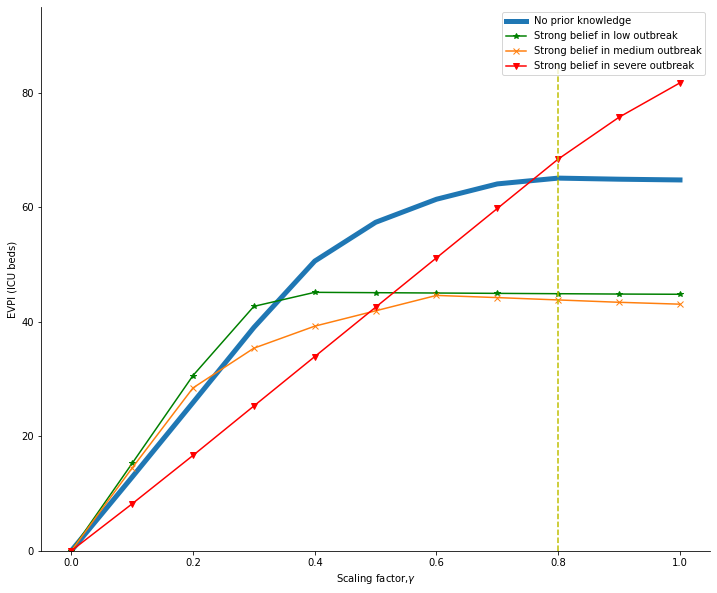

In [35]:
# Plot the above data
maxCol = 1;maxRow = 1
fig, axs = plt.subplots(maxRow, maxCol,figsize=(12, 10))
#fig.suptitle('Sensitivity of the Scaling Factor, $\gamma$ and Belief in States')
axs.plot(gammas,EVPINoPriorKnowledge,lw=5)
axs.plot(gammas,EVPIStrongBeliefInLowOutbreak,marker='*',color='g')
axs.plot(gammas,EVPIStrongBeliefInMediumOutbreak,marker='x')
axs.plot(gammas,EVPIStrongBeliefInSevereOutbreak,marker='v',color='r')

#axs[0].set_title('Strong Belief(0.5)')
#axs[0].set_xlabel('Scaling Factor,$\gamma$ ')
axs.set_xlabel('Scaling factor,$\gamma$ ')
axs.set_ylabel('EVPI (ICU beds)')
axs.legend(['No prior knowledge','Strong belief in low outbreak','Strong belief in medium outbreak','Strong belief in severe outbreak'])
axs.set_ylim([0, 95])
ymin = 0
ymax = 85
axs.vlines(0.8, ymin, ymax, colors='y', linestyles='--', label='EVPXI')

# Hide the right and top spines
axs.spines.right.set_visible(False)
axs.spines.top.set_visible(False)



## Individual PArameter's EVPI Compared

Each parameter is considered as Low, Medium or High without comsidering the effect of other two parameters

In [15]:


#Average (CI95 values) of values where severity = Low, Medium or High
severityData_r4 =  [0,65.0,982.89]  

#Average (CI95 values) of values where Ro = Low, Medium and  High
r0Data_r4 =[30.96, 451.12,565.82] 

childInfData_r4 =[265.0057687,381.8242251,401.0615308]

combinedData = [severityData_r4,r0Data_r4,childInfData_r4]

#Prior Beliefs in states of nature
severityBelief = [0.2, 0.3,0.5]
r0Belief = [0.2,0.3, 0.5]
childInfBelief = [0.2, 0.3, 0.5]

numOfStates = len(severityBelief)

combinedProbability = [[0.33,0.33,0.34],severityBelief,r0Belief,childInfBelief]

[0, 65.0, 982.89]
Length of payoff: 3
Sum of probabilities = 1.0
All EVPIs = [[ 0.    9.9  19.8  29.7  39.6  50.32 55.78 60.24 64.2  65.85 67.5 ]]
Sum of probabilities = 1.0
All EVPIs = [[ 0.  3.  6.  9. 12. 15. 18. 21. 24. 27. 30.]]
Sum of probabilities = 1.0
All EVPIs = [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


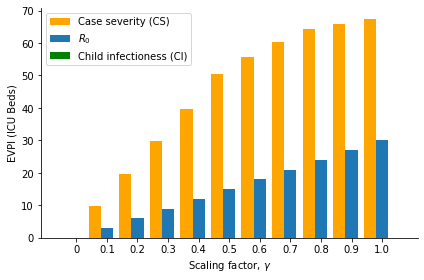

In [20]:
# Repeat for each parameter (R0, CS and CI)

def runPerParameterEVPI():
    analysisType = 'Severity'
    befielfDistrib = 1
    #Use the selected input to load the appropriate payoff and probabilities
    beliefInState,payoffs = loadExperiment(region,analysisType,combinedProbability,combinedData,befielfDistrib)
    print(payoffs)
     
    
    #Validate Inputs and ensure probabilities sum to 1
    payoffNum = np.array(payoffs).shape
    numOfStates = len(beliefInState)
    numberOfActions = len(actions)
    #updatedPayoffs =[[0 for i in range(numOfStates)] for j in range(numberOfActions) ] #updatedPayoffs  = [numberOfActions][numOfStates]
    #validateInputs(beliefInState,payoffs)
    print(f"Length of payoff: {len(payoffs)}")
    
    EVPISeverity = runEVPI(analysisType,payoffs,beliefInState,actions)
    
    
    analysisType = 'R0'
    befielfDistrib = 2
    beliefInState,payoffs = loadExperiment(region,analysisType,combinedProbability,combinedData,befielfDistrib)

    EVPIR0 = runEVPI(analysisType,payoffs,beliefInState,actions)
    
    analysisType = 'ChildInf'
    befielfDistrib = 3
    beliefInState,payoffs = loadExperiment(region,analysisType,combinedProbability,combinedData,befielfDistrib)
    EVPIChildInf = runEVPI(analysisType,payoffs,beliefInState,actions)
   

    labels2 = ['0', '0.1', '0.2', '0.3', '0.4','0.5', '0.6', '0.7', '0.8','0.9', '1.0']

    #EVPISeverity= [[0,   7,   14,   21,   28, 36, 44,  52, 60,  68, 76]] #Run for Severity and collect data
    #EVPIR0 = [[ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27, 30]] #Run for R0 and collect data
    #EVPIChildInf = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

    #Flatten from 2D  to 1-D
    EVPISeverity = list(chain.from_iterable(EVPISeverity))
    EVPIR0 = list(chain.from_iterable(EVPIR0))

    EVPIChildInf = list(chain.from_iterable(EVPIChildInf))

    x = np.arange(len(labels2))  # the label locations
    width = 0.4  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width, EVPISeverity, width, label='Case severity (CS)',color='orange')
    rects2 = ax.bar(x, EVPIR0, width, label='$R_0$')
    rects3 = ax.bar(x + (width), EVPIChildInf, width, label='Child infectioness (CI)',color='green')

    # Hide the right and top spines
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('EVPI (ICU Beds)')
    ax.set_xlabel('Scaling factor, $\gamma$')
    #ax.set_title('EVPI for each Parameter at different Scaling Factor, $\gamma$')
    ax.set_xticks(x)
    ax.set_xticklabels(labels2)
    ax.legend()
    fig.tight_layout()

runPerParameterEVPI()

In [22]:
numOfStates

3

All EVPIs = [[ 0.    7.   14.   21.   28.   35.75 43.8  51.85 59.9  67.95 76.  ]]
All EVPIs = [[ 0.  3.  6.  9. 12. 15. 18. 21. 24. 27. 30.]]
All EVPIs = [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


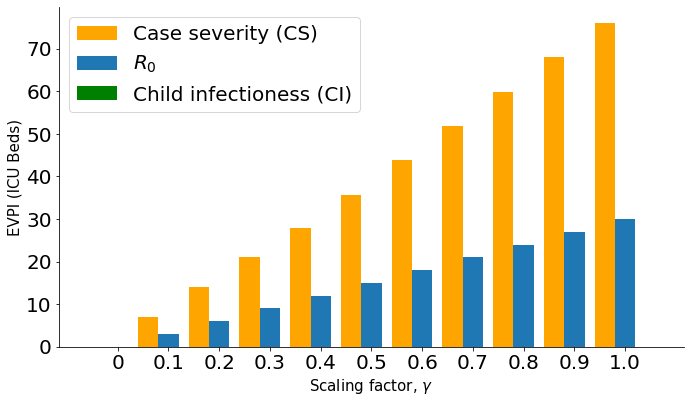

<h2>Compute EVPXI</h2>

In [37]:
befielfDistrib = 3 # 3 is Strong belief in severe outbreak
analysisType = 'All'
beliefInState,payoffs = loadExperiment(region,analysisType,priorBeliefs,reg4Payoffs,befielfDistrib) #Use the selected input to load the appropriate payoff and probabilities
numOfStates = len(beliefInState)
numGammas = len(gammas)
budgetsevpxi = list(gammas)
EVcertntyfalse = [0]*numberOfActions # Strictly used to compute expected value of removing uncertainty for hypothesis x rather than all the hypothesis
EVuncertnty=[0]*numberOfActions
EVPXI=[[0 for i in range(numOfStates)] for j in range(numGammas) ]

countgammaPoints = 0
for gm in range(numGammas):#For each scaling factor (gamma)
    scaleFactor = gammas[gm]
    #updatedPayoffs = generateNewPayoffs(scaleFactor)
    updatedPayoffs = generateNewPayoffs(payoffs,scaleFactor,numberOfActions,numOfStates)
    #print(updatedPayoffs)
    a = np.array(updatedPayoffs)
    for action in range(numberOfActions):
        currentPayoffs = a[action,:]
        EVuncertnty[action] = EVUncertainty(currentPayoffs,beliefInState)
    EVDecisionUncertainty = min(abs(np.array(EVuncertnty))) # Expected Value of Decision Under Uncertainty
    #print(EVDecisionUncertainty)
    
    
    #Compute EVXPI for each State of nature
    for belief in range(numOfStates):
        currentBelief = beliefInState[belief]
        tempState = beliefInState.copy()
        falseBelief = 1 - currentBelief
        del tempState[belief]
        #print(tempState)
        newOtherBeliefs = renormaliseBeliefs(np.array(tempState),falseBelief)
        #print(newOtherBeliefs)
        currActionsperState = a[:,belief] #Get payoffs for each action corresponding to current state of nature
        
        
        absDifferenceWithBudget = abs(np.array(currActionsperState))
        currentStateOptimal = min(absDifferenceWithBudget)
        #print(currActionsperState)
        #print(absDifferenceWithBudget)
        #print(f"Current optimal is: ",currentStateOptimal)
        firstTermOfEVxCertainty = currentStateOptimal*currentBelief
        
        otherActionsPayoff = copy.deepcopy(updatedPayoffs) # Make a copy of the original payoff matrix, https://realpython.com/copying-python-objects/
       
       
        for action in range(numberOfActions):
            toArray = np.array(otherActionsPayoff)
            currPayoffFalse = toArray[action,:]
            cpayoffFalse = list(currPayoffFalse).copy()
            #print(len(cpayoffFalse))
            del  cpayoffFalse[belief]
            #print(len(cpayoffFalse))
            EVcertntyfalse[action] = EVUncertainty(cpayoffFalse,newOtherBeliefs)
        
        EVDecisionCertaintyFalse = min(abs(np.array(EVcertntyfalse))) # Expected Value of Decision Under Certainty For EVPXI
        secondTermofEVxCertainty = falseBelief * EVDecisionCertaintyFalse
        EVCertaintyx = firstTermOfEVxCertainty + secondTermofEVxCertainty
        #print(EVCertaintyx)
        evpxi =  abs(EVCertaintyx - EVDecisionUncertainty)
        EVPXI[gm][belief] = evpxi
        #print(evpxi)
        #EVPXI[belief] = EVCertaintyx - EVDecisionUncertainty
    countgammaPoints = countgammaPoints + 1
    #print(f" gm: {gammas[gm]}")
#print(f" EVPXIs: {np.array(EVPXI)}")
        

In [38]:
print (np.round(EVPXI[10],2))


[1.2  1.8  3.   1.8  2.7  4.5  3.   4.5  2.5  1.8  2.7  4.5  2.7  2.7
 2.32 1.5  2.25 4.81 3.   4.5  7.5  3.   2.06 1.06 2.5  4.81 9.81]


In [39]:
print(f" EVPXIs: {numOfStates}")

 EVPXIs: 27


In [40]:
print(len(EVPXI[7]))

27


<h3> Plots </h3>

In [41]:
#Plot helper functions
def ICUBeds(x, pos):
    'The two args are the value and tick position'
    return '%1.1f' % (x * 1)

formatter = FuncFormatter(ICUBeds)

Text(3, 2.9629200000000084, 'High Enough EVPXI')

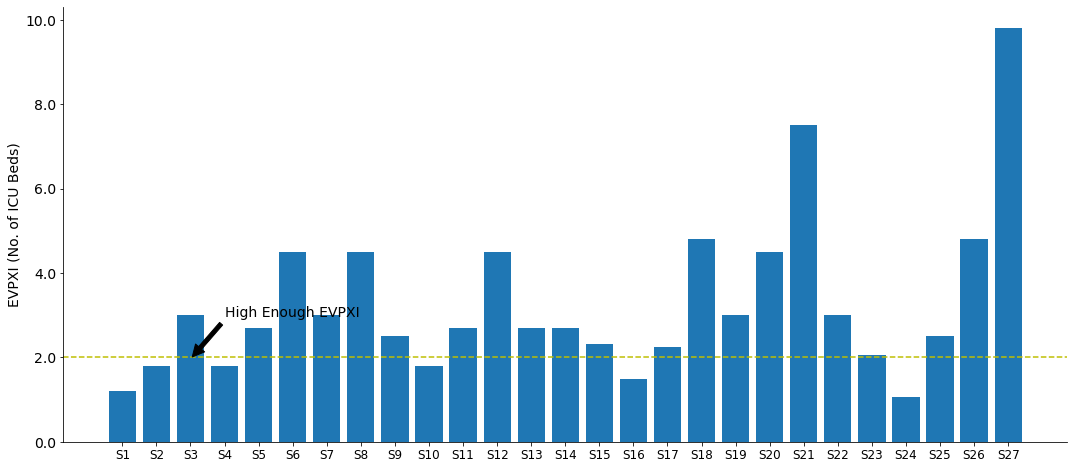

In [44]:
#Plot EVPXI of the budget with largest EVPI

plt.rcParams.update({'font.size': 14})
plt.rc('xtick', labelsize= 12)    # fontsize of the tick labels

evpxi = EVPXI[10] #Select the gamma to plot
x = np.arange(numOfStates)
#x = gammas
if analysisType != "All":
    fig, ax = plt.subplots(figsize=(8, 5))
else:
    fig, ax = plt.subplots(figsize=(18, 8))
ax.yaxis.set_major_formatter(formatter)
#plt.bar(x, abs(np.array(evpxi)))
plt.bar(x, evpxi)
plt.xticks(x, labels)

# Hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
#plt.title(f'EVPXI at $\gamma={1.0}$ and with Strong believe ($p_s = 0.5 $) in Severe Outbreak')
#plt.xlabel('Hypothesis')
plt.ylabel('EVPXI (No. of ICU Beds)')
maxevpxi = max(evpxi)
highEnoughEVPXI = 0.2*maxevpxi

plt.axhline(y=2, color='y', linestyle='--',label='High Enough EVPXI')
#plt.axhline(y=10, color='b', linestyle='-',label='Max EVPXI')
plt.annotate('High Enough EVPXI', xy=(2, highEnoughEVPXI), xytext=(3, highEnoughEVPXI + 1),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
#plt.annotate('Maximum EVPXI', xy=(26.2, maxevpxi), xytext=(9.8, maxevpxi-1),
#            arrowprops=dict(facecolor='black', shrink=0.05),
#            )
#plt.legend()
#plt.grid(color='b', linestyle='--', linewidth=1,which='major', axis='y')

In [356]:

np.round(EVPXI,2)

array([[ 0.  ,  0.  ,  0.  ],
       [ 4.  ,  3.  ,  5.  ],
       [ 8.  ,  6.  , 10.  ],
       [12.  ,  9.  , 16.65],
       [16.  , 12.  , 23.7 ],
       [20.  , 15.75, 30.75],
       [24.  , 19.8 , 37.8 ],
       [28.  , 23.85, 44.85],
       [32.  , 27.9 , 51.9 ],
       [36.  , 31.95, 58.95],
       [40.  , 36.  , 66.  ]])

<Figure size 1080x360 with 0 Axes>

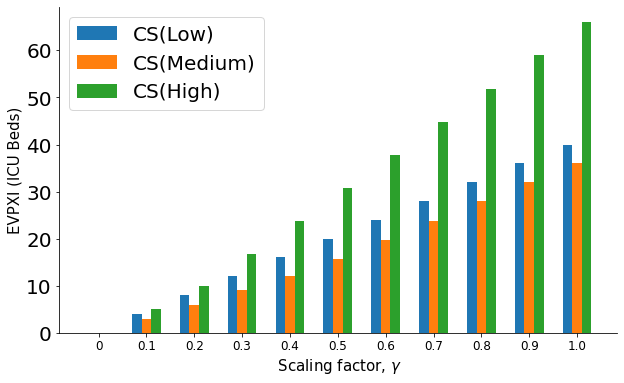

In [357]:
fig = plt.figure(figsize= (15,5))
labels2 = ['0', '0.1', '0.2', '0.3', '0.4','0.5', '0.6', '0.7', '0.8','0.9', '1.0']

Low = np.round(np.array(EVPXI)[:,0],1)
Medium = np.array(EVPXI)[:,1]
High  = np.array(EVPXI)[:,2]


x = np.arange(len(labels2))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, Low, width, label=labels[0])
rects2 = ax.bar(x, Medium, width, label=labels[1])
rects3 = ax.bar(x + width, High, width, label=labels[2])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('EVPXI (ICU Beds)')
ax.set_xlabel(' Scaling factor, $\gamma$')
#ax.set_title('$R_0$: Variation of EVPXI with Scaling Factor, $\gamma$')
ax.set_xticks(x)
ax.set_xticklabels(labels2)
ax.legend()
plt.rcParams.update({'font.size': 20})

SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

# Hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title




#fig.tight_layout()


In [135]:
print(EVPXI[1:])

[[2.999999999999943, 0.0, 0.0], [6.0, 0.0, 0.0], [9.0, 0.0, 0.0], [12.0, 0.0, 0.0], [15.0, 0.0, 0.0], [17.999999999999943, 0.0, 0.0], [21.0, 0.0, 0.0], [24.0, 5.684341886080802e-14, 0.0], [26.999999999999943, 0.0, 0.0], [30.0, 0.0, 0.0]]


In [136]:
print(np.array(EVPXI)[:,0])


[ 0.  3.  6.  9. 12. 15. 18. 21. 24. 27. 30.]


In [74]:
print(EVPXI[10])

[0.0, 0.2675249400000155, 2.842170943040401e-14, 0.0, 1.767524940000044, 2.842170943040401e-14, 2.842170943040401e-14, 0.0, 3.5999999999999943, 0.0, 1.767524940000044, 0.2675249400000155, 2.842170943040401e-14, 5.762822249999971, 8.354023650000016, 4.0, 10.0, 5.999999999999972, 0.0, 0.0, 0.0, 1.0, 7.151351200000022, 4.851363719999995, 1.6000000000000227, 4.0, 2.3999999999999773]


In [107]:
df['actions'] = actionNames
df.set_index("actions",drop=True,inplace=True)

In [108]:
df.tail()

,0,1,2
actions,,,
CI05,0,0,0.000000
CI95,0,0,6.262394
Mean,0,0,1.544850


Text(0.5, 1.0, 'Region1: Payoffs (Costs) for each action')

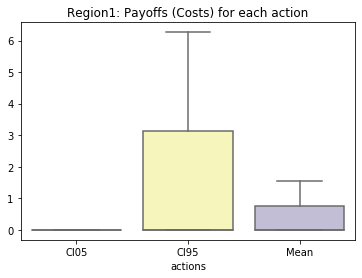

In [109]:
df = df.transpose()
ax = sns.boxplot(data=df,palette="Set3")
plt.title(f'{region}: Payoffs (Costs) for each action')

Text(0.5, 1.0, 'Region1: Payoffs (Costs) for each action')

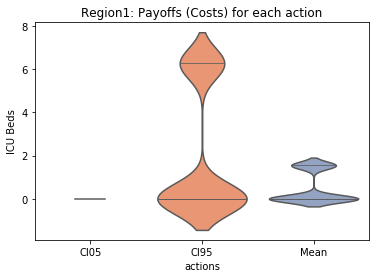

In [110]:
ax = sns.violinplot(data=df,palette="Set2",scale="count", inner="stick",
                    scale_hue=False, bw=.2)
plt.ylabel('ICU Beds')
plt.title(f'{region}: Payoffs (Costs) for each action')

<H1> Study the EVXPI of each of R_0, Severity and Child Infectiousness </H1>

In [137]:
#Functions for batch processing of VoI
def computeEVPI(budget):
    global EVuncertnty,EVDecisionUncertainty
    EVcertain=0 
    # Compute Expected Value of Decision Under Uncertainty
    for action in range(numberOfActions):
        currentPayoffs = a[action,:]
        EVuncertnty[action] = EVUncertainty(currentPayoffs,beliefInState)
    EVDecisionUncertainty = min(abs(np.array(EVuncertnty))) 
    
    #Compute EVcertainty
    for belief in range(numOfStates):
        currentBelief = beliefInState[belief]
        currActionsperState = a[:,belief] #Get payoffs for each action corresponding to current state of nature
        absDifferenceWithBudget = abs(np.array(currActionsperState) - budget)
        currentStateOptimal = min(absDifferenceWithBudget)
        indexofMin=absDifferenceWithBudget.argmin()
        optimumActionForThisState = a[indexofMin][belief]*currentBelief #EMV of optimal decision without considering budget
        #print(f" Hypothesis = {belief},Best Action = Purchase {getActionName(indexofMin) }({int(round(a[indexofMin][belief],0))}) ICU beds")
        thisEV = currentStateOptimal*currentBelief
        EVcertain = EVcertain  + thisEV
    evpi = abs(EVcertain - EVDecisionUncertainty)
    return evpi

def EVPIForBudgets(budgetpoints):
    currentBudget = 0
    numBudgetPoints = len(budgetPoints)
    EVPIForBudgets = [0]*numBudgetPoints
    for budget in budgetPoints:
        EVPIForBudgets[currentBudget] = computeEVPI(budget)
        currentBudget = currentBudget + 1
    return EVPIForBudgets

def computeEVPXI(budget):
    global EVuncertnty,EVDecisionUncertainty
    EVPXIfx = [0]*numOfStates
    for action in range(numberOfActions):
        currentPayoffs = a[action,:]
        EVuncertnty[action] = EVUncertainty(currentPayoffs,beliefInState)
    EVDecisionUncertainty = min(abs(np.array(EVuncertnty) - budget)) # Expected Value of Decision Under Uncertainty
    
    #Compute EVXPI for each State of nature/hypothesis
    for belief in range(numOfStates):
        currentBelief = beliefInState[belief]
        tempState = beliefInState.copy()
        falseBelief = 1 - currentBelief
        del tempState[belief]
        #print(tempState)
        newOtherBeliefs = renormaliseBeliefs(np.array(tempState),falseBelief)
        #print(newOtherBeliefs)
        currActionsperState = a[:,belief] #Get payoffs for each action corresponding to current state of nature
        
        
        absDifferenceWithBudget = abs(np.array(currActionsperState) - budget)
        currentStateOptimal = min(absDifferenceWithBudget)
        
        firstTermOfEVxCertainty = currentStateOptimal*currentBelief
        
        otherActionsPayoff = copy.deepcopy(payoffs) # Make a copy of the original payoff matrix, https://realpython.com/copying-python-objects/
        otherActionsPayof = removeCurrentPayoffs(otherActionsPayoff,belief) #Remove the Payoff for the state whose EVPXI is being computed
        #print(otherActionsPayof)
        for action in range(numberOfActions):
            toArray = np.array(otherActionsPayof)
            currPayoffFalse = toArray[action,:]
            EVcertntyfalse[action] = EVUncertainty(currPayoffFalse,newOtherBeliefs)
        
        EVDecisionCertaintyFalse = min(abs(np.array(EVcertntyfalse) - budget)) # Expected Value of Decision Under Certainty For EVPXI
        secondTermofEVxCertainty = falseBelief * EVDecisionCertaintyFalse
        EVCertaintyx = firstTermOfEVxCertainty + secondTermofEVxCertainty
        #EVPXI[countBugetPoints][belief] = abs(EVCertaintyx - EVDecisionUncertainty)
        EVPXIfx[belief] = EVCertaintyx - EVDecisionUncertainty
    return EVPXIfx

def EVPXIForBudgets(budgetpoint):
    currentBudget = 0
    numBudgetPoints = len(budgetPoints)
    EVPXIForBudgets = [0]*numBudgetPoints
    for budget in budgetPoints:
        EVPXIForBudgets[currentBudget] = computeEVPXI(budget)
        currentBudget = currentBudget + 1
    return EVPXIForBudgets
    
        

In [138]:
print(EVPXI[10])

[30.0, 0.0, 0.0]


In [139]:
#Run EVPI first to find the budget with highest EVPI
budgetPoints = range(0,1700,5)
budgets = list(budgetPoints)
numBudgetPoints = len(budgetPoints)
EVPI = [0]*numBudgetPoints
EVPI = EVPIForBudgets(budgets)
#Prepare to run EVPXI with the budget with maximum EVPI
indexOfMaxEVPI = np.array(EVPI).argmax()
budgetWithMaxEVPI = budgets[indexOfMaxEVPI]
print (f"Max EVPI: {max(EVPI)}, Budget with Max EVPI: {budgetWithMaxEVPI} ICU beds, Index of the budget: {indexOfMaxEVPI}")
#print (EVPI)
budget = budgetWithMaxEVPI #Use this to run EVPXI for each parameter

Max EVPI: 950.8919999999998, Budget with Max EVPI: 1695 ICU beds, Index of the budget: 339


In [155]:
#Prepare plot windows
#Initialise variables
numOfRegions = len(allRegions)
numOfAnalysis = len(allAnalysisTypes)
regCount = 0; analysisCount = 0;countBugetPoints = 0


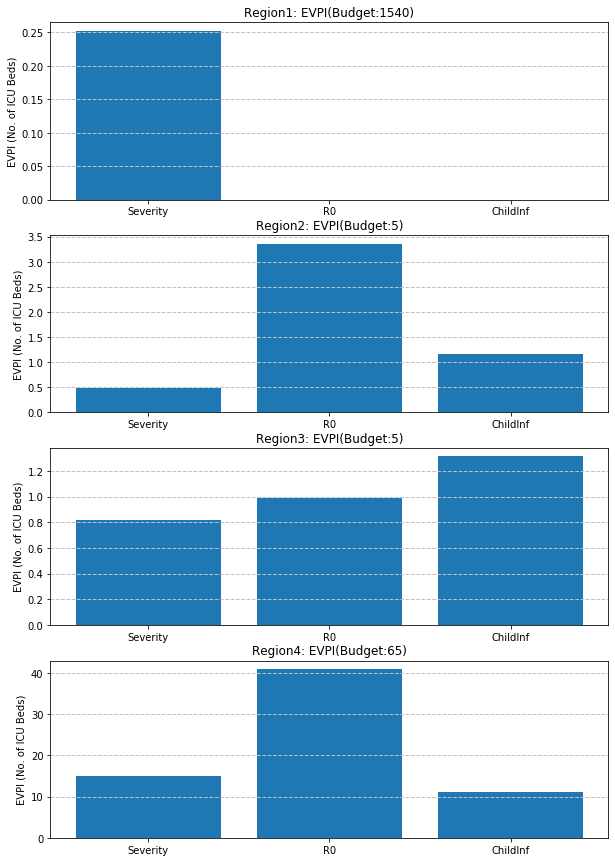

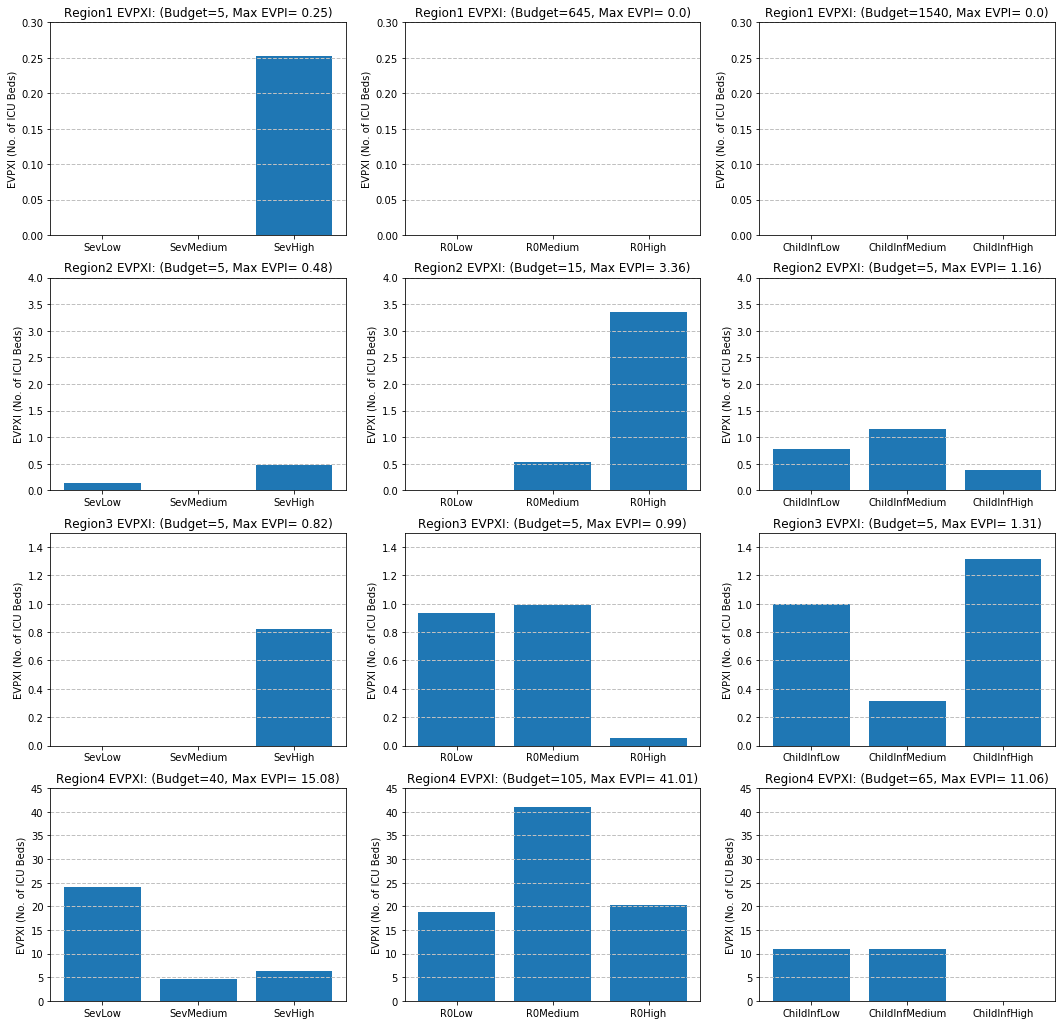

In [158]:
#Try running all experiments in one go
fig, axs = plt.subplots(numOfRegions,figsize=(10, 15))
numSubplotsCount=1


#fig2 = plt.figure(figsize=(20, 20))
fig2, axs2 = plt.subplots(numOfRegions, numOfAnalysis,figsize=(18, 18))
EVPI2 =[[0 for i in range(numOfAnalysis)] for j in range(numOfRegions) ] #EVPI = [numOfRegions][numOfAnalysis]

#EVPXIForBudgets2 = [[0]*numOfAnalysis]*numOfRegions
#fig.suptitle('EVPI plots')
 
for reg in allRegions: #For each region carry out Severity, R0, ChildInfectiousness, and Combined PArameter Analysis of VoI
    if reg=='Region1':
        ylimit = 0.3
    elif reg=='Region2':
        ylimit = 4
    elif reg=='Region3':
        ylimit = 1.5
    elif reg=='Region4':
        ylimit = 45 
    for analysis in allAnalysisTypes:
        payoffs = []
        beliefInState = []
        labels = []
        loadExperiment(reg,analysis)
        payoffNum = np.array(payoffs).shape
        numOfStates = len(beliefInState)
        numberOfActions = payoffNum[0]
        EVuncertnty=[0]*numberOfActions
        EVcertain = 0
        EVcertntyfalse = [0]*numberOfActions # Strictly used to compute expected value of removing uncertainty for hypothesis x rather than all the hypothesis
        EVPXIForBudgets2 = [[[0 for i in range(numOfStates)] for j in range(numOfAnalysis) ] for k in range(numOfRegions)]
        #validateInputs()
        a = np.array(payoffs)
        EVPI = [0]*numBudgetPoints
        EVPI = EVPIForBudgets(budgets)
        
        #Prepare to run EVPXI with the budget with maximum EVPI
        indexOfMaxEVPI = np.array(EVPI).argmax()
        maxEVPI = max(EVPI)
        budgetWithMaxEVPI = budgets[indexOfMaxEVPI]
        budget = budgetWithMaxEVPI #Use this to run EVPI and EVPXI for each parameter
        EVPI2[regCount] [analysisCount]= computeEVPI(budget)
        EVPXIForBudgets2[regCount] [analysisCount]= computeEVPXI(budget)
        x = labels
        #print(labels)
       
        numSubplotsCount = numSubplotsCount +1
        
        #axs2[regCount,analysisCount].plot(x,EVPXIForBudgets2[regCount][analysisCount],ls='--',color ='r')#axs2[regCount,analysisCount]
        axs2[regCount][analysisCount].bar(x, EVPXIForBudgets2[regCount][analysisCount])
        
        axs2[regCount][analysisCount].set_title(f'{reg} EVPXI: (Budget={budgetWithMaxEVPI}, Max EVPI= {round(EVPI[indexOfMaxEVPI],2)})')
        axs2[regCount][analysisCount].set_ylabel('EVPXI (No. of ICU Beds)')
        axs2[regCount][analysisCount].grid(color='#C0C0C0', linestyle='--', linewidth=1,which='major', axis='y')
        a=max(EVPXIForBudgets2[regCount])
        thisRegionsylim = max(a)  #The largest value across all parameters for this region
        #axs2[regCount,analysisCount].set_ylim([0, thisRegionsylim + 0.1*thisRegionsylim])
        axs2[regCount,analysisCount].set_ylim([0, ylimit])
        analysisCount = analysisCount + 1
    x = allAnalysisTypes
    #print(EVPI2)
    axs[regCount].bar(x, EVPI2[regCount])
    axs[regCount].set_ylabel('EVPI (No. of ICU Beds)')
    axs[regCount].grid(color='#C0C0C0', linestyle='--', linewidth=1,which='major', axis='y')
    axs[regCount].set_title(reg + ': EVPI(' + 'Budget:' + str(budget) + ')')
    
    regCount = regCount + 1
    analysisCount = 0
regCount=0
#print (EVPI)